# Part 1 of 6: Import key packages & data

In [7]:
### key imports

#-- get packages

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, classification_report
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib import gridspec
from matplotlib import style
from matplotlib.dates import HourLocator, DateFormatter
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Normalize

!pip install statsmodels
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
import scipy.stats as stats
from scipy.stats import skew, kurtosis, kstest, shapiro, normaltest, anderson, kstest, wilcoxon, mannwhitneyu, spearmanr, boxcox, yeojohnson

#-- get data

ShareLink_loan_data = 'https://drive.google.com/file/d/1TTUjEsircjxU_4armc9k14zIfNAqOTf0/view?usp=sharing'

df = pd.read_csv('https://drive.google.com/uc?id=' + ShareLink_loan_data.split('/')[-2])

df_backup = df.copy()

#-- view basic info

print('#-- view head of data')
print(df.head())
print('')

print('#-- view column types & amount of non-NaNs in columns')
print(df.info())
print('')



#-- view head of data
    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N 

# Part 2: Handle missing values & identify potential outliers

In [8]:
### handle NaNs; convert categorical data to numerical data

#-- investigate NaNs

df_FracNans = df.isna().sum() / len(df) # 5% will show up as 0.05

print('#-- view fraction of NaNs in each column')
print(df_FracNans)
print('')

#-- fill NaNs - for categorical data, fill NaNs with the mode

list_CatCols = ['Self_Employed','Married','Education','Gender','Loan_Status','Dependents','Property_Area','Credit_History']

for col in list_CatCols:
  df[col] = df[col].fillna(df[col].mode()[0])

#-- fill NaNs - for non-categorical data, fill NaNs with the median

list_NonCatCols = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term']

for col in list_NonCatCols:
  df[col] = df[col].fillna(df[col].median())

#-- convert binary categories to 0 and 1

df.replace({
    'Self_Employed': {'No': 0, 'Yes': 1},
    'Married': {'No': 0, 'Yes': 1},
    'Education': {'Not Graduate': 0, 'Graduate': 1},
    'Gender': {'Male': 0, 'Female': 1},
    'Loan_Status': {'No': 0, 'Yes': 1}
}, inplace=True)

#-- convert categories with more than 2 options to dummy variables

y = df['Loan_Status']
x = df.drop(['Loan_Status', 'Loan_ID'], axis=1)

x = pd.get_dummies(data=x, columns=['Dependents', 'Property_Area'] )


#-- view fraction of NaNs in each column
Loan_ID              0.000000
Gender               0.021173
Married              0.004886
Dependents           0.024430
Education            0.000000
Self_Employed        0.052117
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           0.035831
Loan_Amount_Term     0.022801
Credit_History       0.081433
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64



In [9]:
### check for potential outliers using Tukey fences

def get_tukey_outliers(df, col, multiplier=1.5):
  dfz = df.copy()[[col]].dropna()
  q1, q3 = df[col].quantile(0.25), df[col].quantile(0.75)
  IQR = q3 - q1
  list_outliers = [x for x in dfz[col].values if (x > q3 + multiplier*IQR) | (x < q1 - multiplier*IQR)]
  return list_outliers

dfo = df.copy()

list_NonCatCols = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term']

dict_ColOutliers = {}

for col in list_NonCatCols:
  list_PossibleOutliers = get_tukey_outliers(df=dfo, col=col, multiplier=2.5)
  dict_ColOutliers[col] = list_PossibleOutliers

  count_outliers = len(list_PossibleOutliers)
  frac_outliers = count_outliers / len(dfo[col])

  print(f'### Looking at column [{col}]')
  print(f'# Number of potential outliers: {len(list_PossibleOutliers)}')
  print(f'# Fraction of data that represents: {100*frac_outliers:.1f}%')
  print(f'# View 5 potential outliers')
  print(list_PossibleOutliers[:5])
  print('')



### Looking at column [ApplicantIncome]
# Number of potential outliers: 34
# Fraction of data that represents: 5.5%
# View 5 potential outliers
[13650, 14583, 23803, 20166, 14999]

### Looking at column [CoapplicantIncome]
# Number of potential outliers: 9
# Fraction of data that represents: 1.5%
# View 5 potential outliers
[10968.0, 8106.0, 8980.0, 11300.0, 20000.0]

### Looking at column [LoanAmount]
# Number of potential outliers: 22
# Fraction of data that represents: 3.6%
# View 5 potential outliers
[349.0, 370.0, 650.0, 600.0, 700.0]

### Looking at column [Loan_Amount_Term]
# Number of potential outliers: 88
# Fraction of data that represents: 14.3%
# View 5 potential outliers
[120.0, 240.0, 180.0, 180.0, 60.0]



# Part 3: View distributions of numerical columns; assess skew & normality

### View df of rejection bools - if true, normality is rejected
                  kstest shapiro D'Agostino's K^2 Anderson-Darling  \
ApplicantIncome     True    True             True             True   
CoapplicantIncome   True    True             True             True   
LoanAmount          True    True             True             True   
Loan_Amount_Term    True    True             True             True   

                   bool_normal  
ApplicantIncome              0  
CoapplicantIncome            0  
LoanAmount                   0  
Loan_Amount_Term             0  



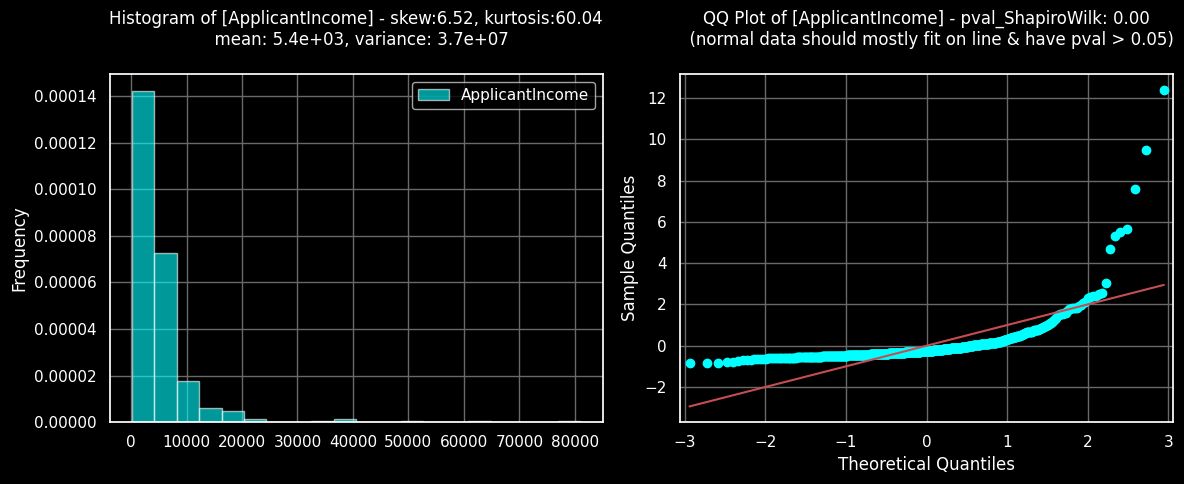

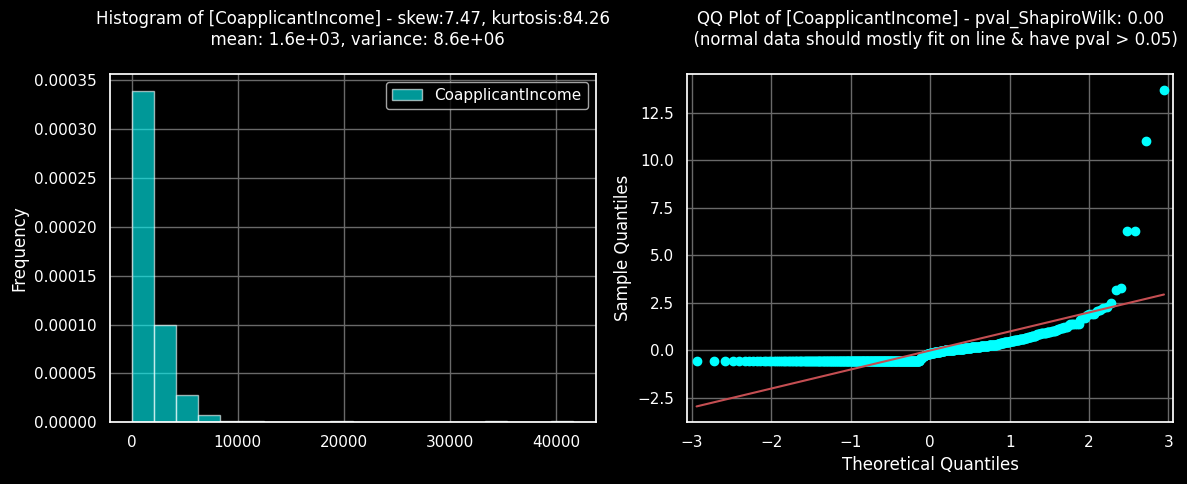

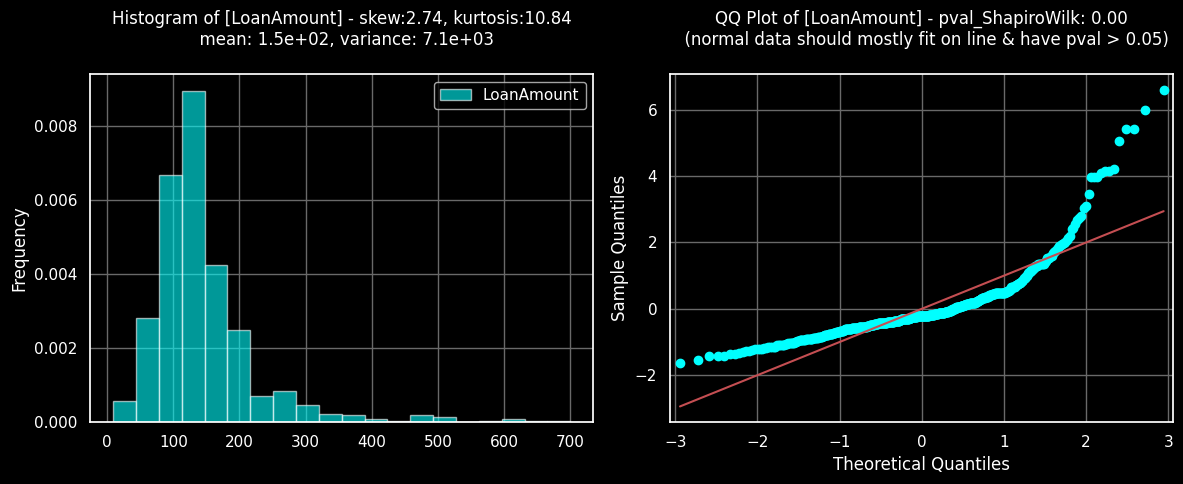

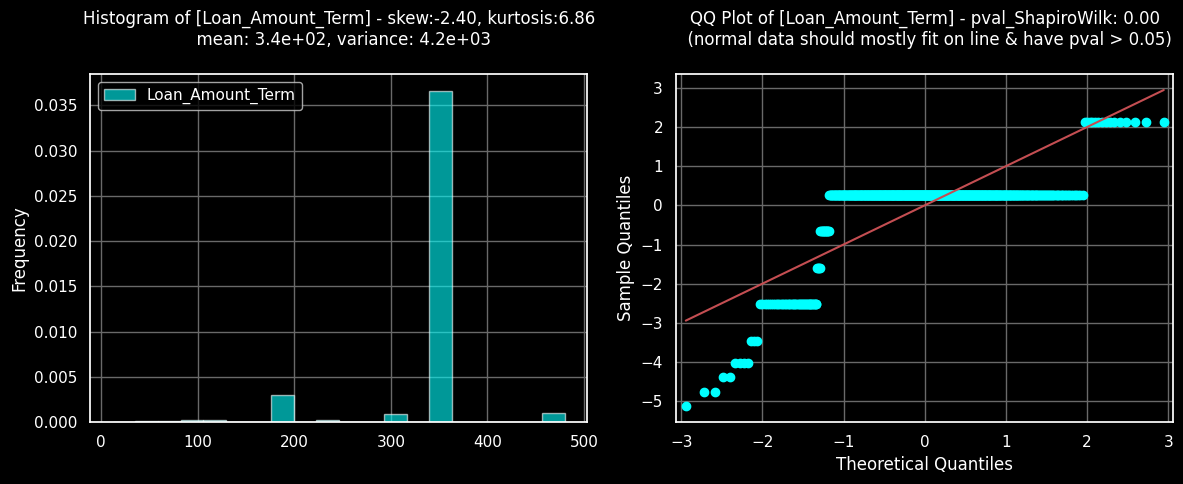

In [13]:
### View distributions of numerical columns - assess skew & normality

dfs = df.copy()

list_NonCatCols = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term']

alpha_NormTests = 0.05 # either 0.01, 0.025, or 0.05

df_RejectBools = pd.DataFrame(index=list_NonCatCols, columns=['kstest', 'shapiro', "D'Agostino's K^2", "Anderson-Darling"])

for col in list_NonCatCols[:]:
  col_mean = dfs[col].mean()
  col_var = dfs[col].var()
  col_skew = skew(dfs[col], nan_policy='omit')
  col_kurtosis = kurtosis(df[col], nan_policy='omit')

  # run normality tests

  TestStat_KS, pval_KS = stats.kstest(dfs[col].dropna(),'norm')
  BoolReject_KS = pval_KS < alpha_NormTests

  TestStat_shapiro, pval_shapiro = shapiro(dfs[col].dropna())
  BoolReject_shapiro = pval_shapiro < alpha_NormTests

  TestStat_dagostino, pval_dagostino = normaltest(dfs[col].dropna())
  BoolReject_dagostino = pval_dagostino < alpha_NormTests

  TestStat_AD, crit_AD, sig_AD = anderson(dfs[col].dropna(), dist='norm')
  dict_AD = {}
  for num_i, level in enumerate(sig_AD):
    crit_val = crit_AD[num_i]
    dict_AD[level/100] = crit_val
  BoolReject_AD = TestStat_AD > dict_AD[alpha_NormTests]

  df_RejectBools.loc[col] = BoolReject_KS, BoolReject_shapiro, BoolReject_dagostino, BoolReject_AD

  # make plots

  from matplotlib import gridspec
  plt.style.context("dark_background")
  plt.style.use('dark_background')
  sns.set(rc={'axes.facecolor': 'k', 'figure.facecolor': 'k'})
  plt.style.use("dark_background")
  num_colors = 4
  color = plt.cm.cool(np.linspace(0, 1, num_colors))
  cyc = plt.cycler('color', color)
  plt.rc('axes', prop_cycle=cyc)

  fig = plt.figure(figsize=(12, 5 ))
  gs = gridspec.GridSpec(1, 2, height_ratios=[1], width_ratios=[1, 1])
  ax1 = plt.subplot(gs[0])
  ax2 = plt.subplot(gs[1])

  title_hist = f"""Histogram of [{col}] - skew:{col_skew:.2f}, kurtosis:{col_kurtosis:.2f}
  mean: {col_mean:{".2f" if len(str(col_mean))<5 else ".1e"}}, variance: {col_var:{".2f" if len(str(col_var))<5 else ".1e"}}
  """

  title_QQ = f"""QQ Plot of [{col}] - pval_ShapiroWilk: {pval_shapiro:.2f}
  (normal data should mostly fit on line & have pval > 0.05)
  """

  dfs[[col]].plot.hist(alpha=0.6, density=1, bins=20, ax=ax1, title=title_hist)
  sm.graphics.qqplot(data=df[col].dropna(), line='s', fit=True, ax=ax2)

  ax2.set_title(title_QQ)

  ax1.grid(c='dimgray')
  ax2.grid(c='dimgray')

  plt.tight_layout()

df_RejectBools['bool_normal'] = (df_RejectBools[['kstest', 'shapiro', "D'Agostino's K^2", "Anderson-Darling"]].sum(axis=1) == 0)*1

print('### View df of rejection bools - if true, normality is rejected')
print(df_RejectBools)
print('')


# Part 4: Split data & run the Random Forest classifier model

In [24]:
### split data; get list of features; define function to fit and evaluate model
#-- note: shuffle can be set to "True" since no time series are involved here

#-- split data & define function for fitting and running the model

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=0, shuffle=True)
features = list(x.columns)

def model_fit_and_eval(x_train, x_test, y_train, y_test, max_depth=5, min_samples_split=0.01, max_features=0.8, max_samples=0.8):
  random_forest = RandomForestClassifier(random_state=0,
                                         max_depth=max_depth,
                                         min_samples_split=min_samples_split,
                                         max_features=max_features,
                                         max_samples=max_samples)

  model = random_forest.fit(x_train, y_train)
  random_forest_predict = random_forest.predict(x_test)
  random_forest_conf_matrix = confusion_matrix(y_test, random_forest_predict)
  random_forest_acc_score = accuracy_score(y_test, random_forest_predict)
  random_forest_class_report = classification_report(y_test, random_forest_predict)

  return model, random_forest_conf_matrix, random_forest_acc_score, random_forest_class_report

#-- try the model and view performance metrics

model, conf_matrix, acc_score, class_report = model_fit_and_eval(x_train, x_test, y_train, y_test)

print('#-- view confusion matrix')
print(conf_matrix)
print('')

print('#-- view accuracy score (between 0 and 1)')
print(f'{acc_score:.3f}')
print('')

print('#-- view classification report')
print(class_report)
print('')



#-- view confusion matrix
[[ 19  24]
 [  2 109]]

#-- view accuracy score (between 0 and 1)
0.831

#-- view classification report
              precision    recall  f1-score   support

           N       0.90      0.44      0.59        43
           Y       0.82      0.98      0.89       111

    accuracy                           0.83       154
   macro avg       0.86      0.71      0.74       154
weighted avg       0.84      0.83      0.81       154




# Part 5: View most important features

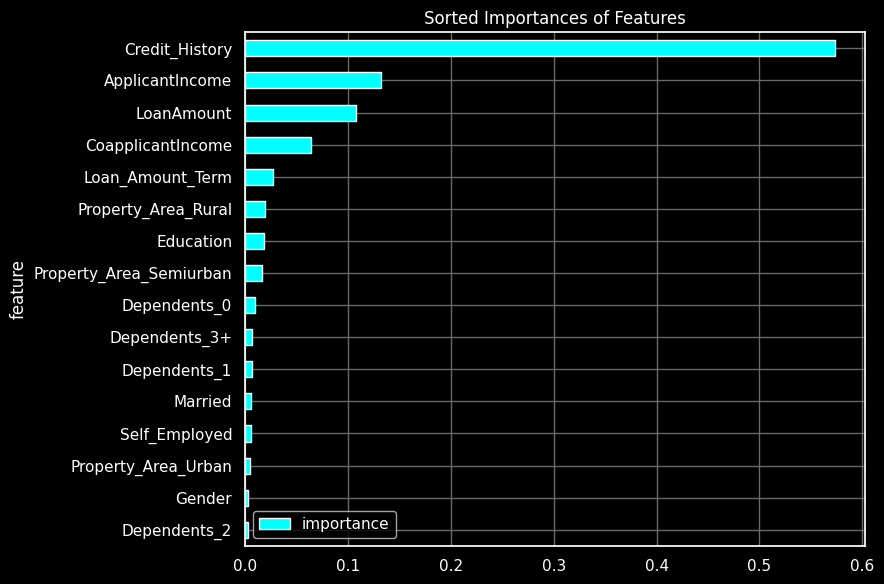

In [25]:
### view feature importances

#-- format dataframe of importances

importances = pd.DataFrame(model.feature_importances_)
importances['features'] = features
importances.columns = ['importance', 'feature']
importances.sort_values(by=['importance'], ascending=True, inplace=True)

#-- plot

from matplotlib import gridspec
plt.style.context("dark_background")
plt.style.use('dark_background')
sns.set(rc={'axes.facecolor': 'k', 'figure.facecolor': 'k'})
plt.style.use("dark_background")
num_colors = 4
color = plt.cm.cool(np.linspace(0, 1, num_colors))
cyc = plt.cycler('color', color)
plt.rc('axes', prop_cycle=cyc)

fig = plt.figure(figsize=(9, 6))
gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1])
ax1 = plt.subplot(gs[0])

importances.plot.barh(x='feature', ax=ax1, title='Sorted Importances of Features')

ax1.grid(c='dimgray')

plt.tight_layout()



# Part 6: Tune hyperparameters using GridSearchCV

In [26]:
### use GridSearchCV to see if other model parameters work better

param_grid = [{
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [0.01, 0.03, 0.07, 0.10],
    'max_features': [0.7, 0.8, 0.9, 1.0],
    'max_samples': [0.7, 0.8, 0.9, 1.0]
}]

model = RandomForestClassifier()

search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=0)
search.fit(x_train, y_train)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by=['mean_test_score'], ascending=[False], inplace=True)

print(f'### view top 10 results of GridSearchCV')
print(results.head(10))
print('')

#-- view best params

print(f'### view best params')
print(search.best_params_)
print('')


### view top 10 results of GridSearchCV
     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
70        0.195381      0.005496         0.009142        0.000723   
131       0.209108      0.018275         0.010822        0.002469   
11        0.188235      0.010015         0.009718        0.001746   
211       0.197639      0.006149         0.009474        0.000859   
0         0.204690      0.009146         0.010596        0.002329   
19        0.205372      0.014961         0.009848        0.000576   
82        0.187661      0.008687         0.008501        0.000162   
45        0.253300      0.055650         0.010747        0.002501   
23        0.266395      0.062805         0.012391        0.002806   
31        0.199124      0.008920         0.010912        0.003193   

    param_max_depth param_max_features param_max_samples  \
70                5                0.7               0.8   
131               7                0.7               0.7   
11                3 

In [27]:
### evaluate model that uses best parameters; get predictions as well

#-- implement best params in model

max_depth_i, max_features_i, max_samples_i, min_samples_split_i = search.best_params_.values()

model, conf_matrix, acc_score, class_report = model_fit_and_eval(
    x_train,
    x_test,
    y_train,
    y_test,
    max_depth=max_depth_i,
    max_features=max_features_i,
    max_samples=max_samples_i,
    min_samples_split=min_samples_split_i
)

print('#-- using best params - view confusion matrix')
print(conf_matrix)
print('')

print('#-- using best params - view accuracy score (between 0 and 1)')
print(f'{acc_score:.3f}')
print('')

print('#-- using best params -  view classification report')
print(class_report)
print('')

#-- get predictions & probabilities

rf_preds = model.predict(x_test)
rf_probs = model.predict_proba(x_test)

print('#-- using best params -  view first 10 predictions & probabilities')
print(rf_preds[:10])
print(rf_probs[:10])
print('')


#-- using best params - view confusion matrix
[[ 19  24]
 [  2 109]]

#-- using best params - view accuracy score (between 0 and 1)
0.831

#-- using best params -  view classification report
              precision    recall  f1-score   support

           N       0.90      0.44      0.59        43
           Y       0.82      0.98      0.89       111

    accuracy                           0.83       154
   macro avg       0.86      0.71      0.74       154
weighted avg       0.84      0.83      0.81       154


#-- using best params -  view first 10 predictions & probabilities
['Y' 'Y' 'Y' 'Y' 'Y' 'N' 'Y' 'Y' 'N' 'Y']
[[0.19394715 0.80605285]
 [0.18089619 0.81910381]
 [0.29794123 0.70205877]
 [0.18458541 0.81541459]
 [0.15208822 0.84791178]
 [0.88632707 0.11367293]
 [0.23633972 0.76366028]
 [0.27945404 0.72054596]
 [0.91084475 0.08915525]
 [0.17968693 0.82031307]]

